### Kelompok 9
- Zaenal Mahmudi Isma'il 05111840000054
- Edo Dwi Yogatama 05111840000060

In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score,accuracy_score,recall_score,classification_report 
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

### Read Dataset
Read Dataset saved and drop id column as we know it doesnt effect the responses class

In [2]:
df = pd.read_csv('./train.csv')
df = df.drop('id', axis='columns')
df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


### Dataset Statistical
Mendapatkan Deskripsi dari dataset untuk mencari mean, std, min, max, quartile, modus, dan frekuensi

Numerical data dapat dicari mean, std, min, max, quartile dan modus nya. Namun categorical data kami dapat mengambil jumlah frekuensi data dan mendapatkan modus nya

In [3]:
categorical = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']
numerical = ['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

statistic = df.describe()

mode = df.mode()
mode = pd.DataFrame(mode.iloc[0]).transpose()
statistic = pd.concat([statistic, mode])

statistic = statistic[numerical]
statistic

,Age,Annual_Premium,Policy_Sales_Channel,Vintage
count,381109.0,381109.0,381109.0,381109.0
mean,38.822584,30564.389581,112.034295,154.347397
std,15.511611,17213.155057,54.203995,83.671304
min,20.0,2630.0,1.0,10.0
25%,25.0,24405.0,29.0,82.0
50%,36.0,31669.0,133.0,154.0
75%,49.0,39400.0,152.0,227.0
max,85.0,540165.0,163.0,299.0
0,24,2630.0,152.0,256


In [4]:
tmp = []
for col in categorical:
    tmp.append(pd.DataFrame(df[col].value_counts()).transpose())
    
for freq in tmp:
    print(freq,"\n")

          Male  Female
Gender  206089  175020 

                      1    0
Driving_License  380297  812 

                         0       1
Previously_Insured  206481  174628 

             1-2 Year  < 1 Year  > 2 Years
Vehicle_Age    200316    164786      16007 

                   Yes      No
Vehicle_Damage  192413  188696 



### Cleaning Dataset
- Melihat datatype yang terdapat pada dataset, supaya perlakuan untuk mengidetifikasi missing value tertangani
- Untuk memastikan bahwa tidak ada missing value, kami mencari data yang "null" untuk numerical data, dan empty untuk categorical data dengan string

In [5]:
df.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [6]:
np.where(pd.isnull(df))

(array([], dtype=int64), array([], dtype=int64))

In [7]:
np.where(df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

- Check apakah terdapat data yang duplikat

In [8]:
duplicate = df[df.duplicated()]

duplicate

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
35754,Male,23,1,15.0,0,< 1 Year,No,2630.0,152.0,173,0
41515,Male,39,1,30.0,0,1-2 Year,Yes,2630.0,124.0,27,0
43618,Male,40,1,28.0,1,1-2 Year,No,2630.0,124.0,209,0
44049,Male,39,1,28.0,0,1-2 Year,Yes,2630.0,124.0,64,0
44203,Male,44,1,28.0,0,> 2 Years,Yes,2630.0,124.0,155,1
...,...,...,...,...,...,...,...,...,...,...,...
379273,Male,58,1,30.0,1,1-2 Year,No,2630.0,152.0,150,0
379451,Male,41,1,30.0,0,1-2 Year,Yes,2630.0,156.0,111,0
379788,Male,38,1,28.0,1,1-2 Year,No,2630.0,124.0,42,0
380673,Female,37,1,28.0,0,1-2 Year,Yes,2630.0,156.0,176,0


- Check apabila terdapat outlier, kami memilih untuk drop row yang terdapat data outlier tersebut
```
Belum dapat mengidetifikasi mana yang outlier dan bagaimana mendeteksi outlier pada categorical data
```

<AxesSubplot:xlabel='Age'>

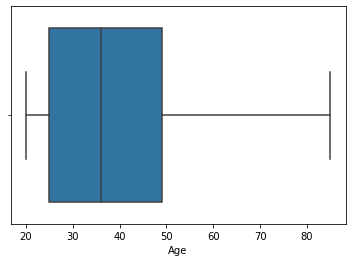

In [9]:
sns.boxplot(x=df['Age'])

<AxesSubplot:xlabel='Annual_Premium'>

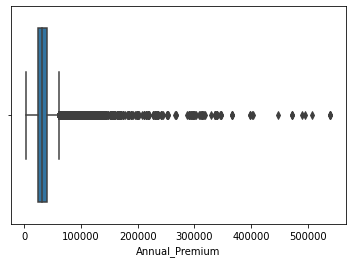

In [10]:
sns.boxplot(x=df['Annual_Premium'])

<AxesSubplot:xlabel='Policy_Sales_Channel'>

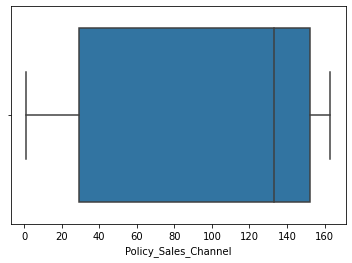

In [11]:
sns.boxplot(x=df['Policy_Sales_Channel'])

<AxesSubplot:xlabel='Vintage'>

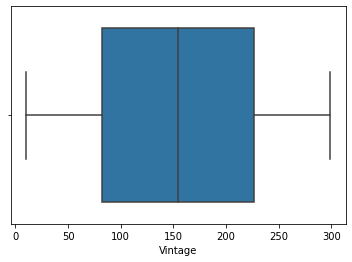

In [12]:
sns.boxplot(x=df['Vintage'])

- Check apakah dataset imbalance
- Pada kasus ini, dataset imbalance, dikeranekan jumlah data dengan Response (sebagai label class) 0 dan 1 terpaut jauh

<Figure size 720x720 with 0 Axes>

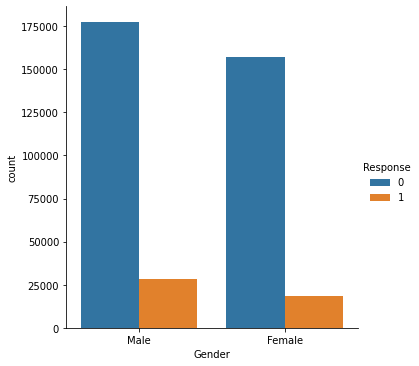

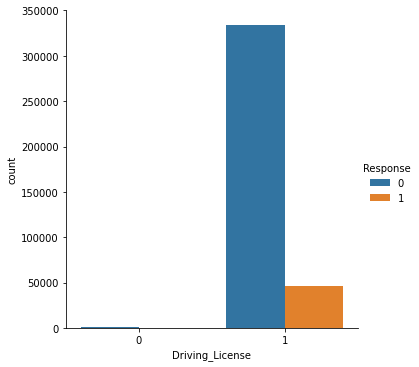

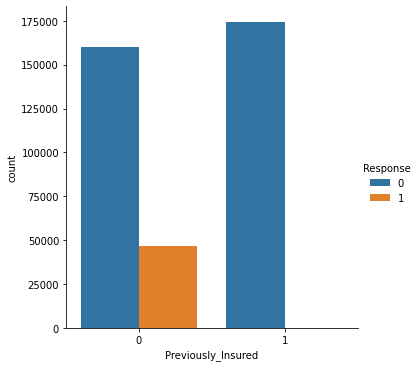

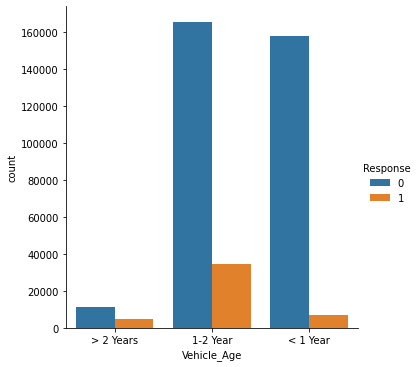

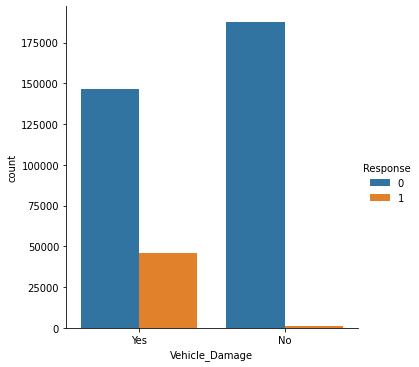

In [13]:
plt.figure(figsize=(10, 10))
for col in categorical:
    sns.catplot(x=col, hue="Response", kind="count", data=df)
    
plt.show()

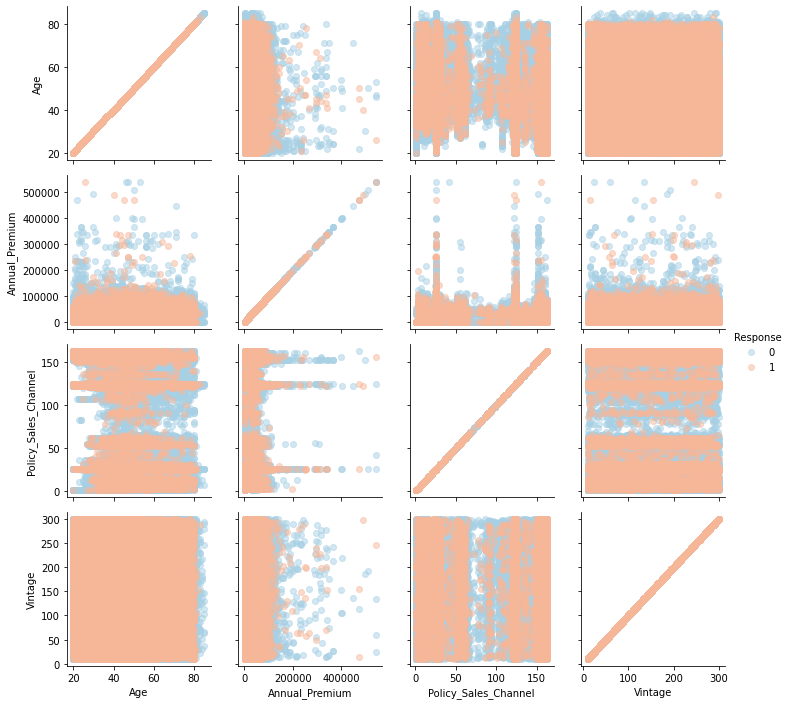

In [14]:
G = sns.PairGrid(df, vars=numerical,hue='Response', palette='RdBu_r')
G.map(plt.scatter, alpha=0.5)
G.add_legend();

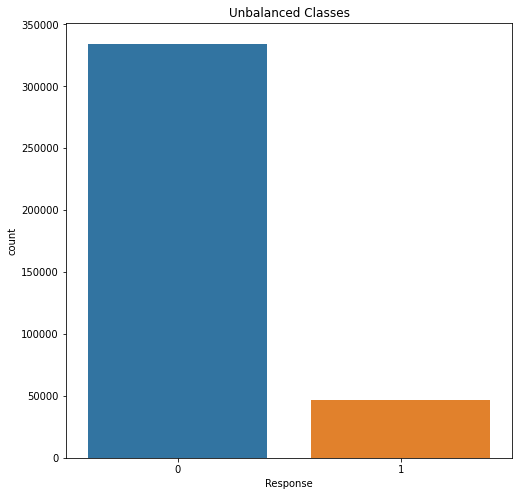

In [15]:
plt.figure(figsize=(8, 8))
sns.countplot(x='Response', data=df)
plt.title('Unbalanced Classes')
plt.show()

### Correlation Map
untuk mengetahui korelasi antar attribut pada datset

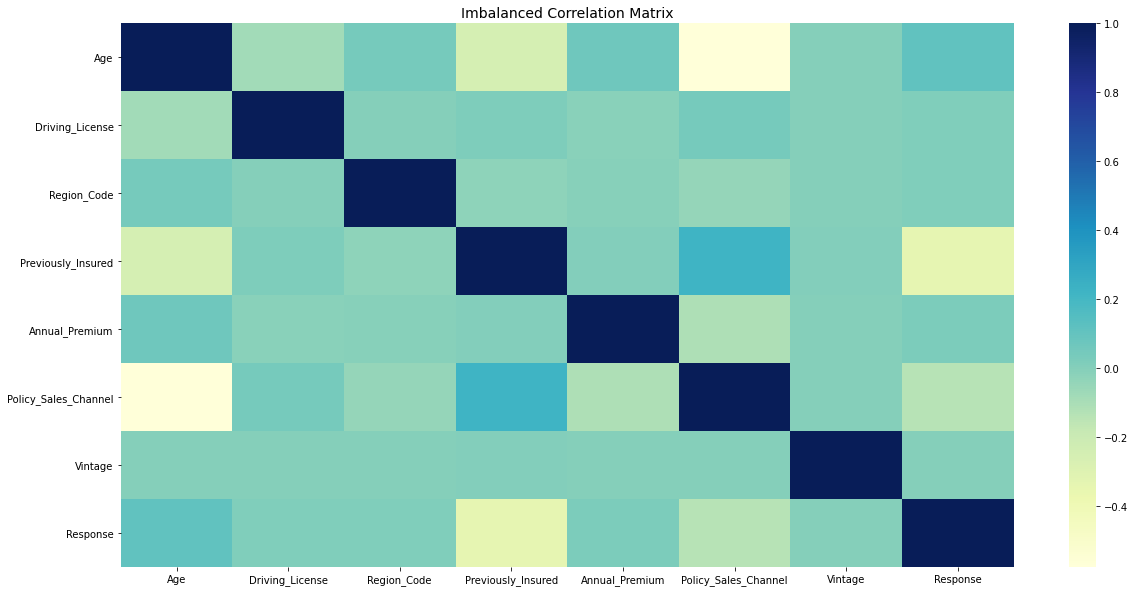

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
corr = df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

### Undersampling
Undersampling kelas 0 sehingga jumlah data yang terdapat pada kelas 0 sama dengan jumlah data pada kelas 1
```
masalah terhadap jumlah n yang dibentuk untuk undersampling baiknya berapa
```

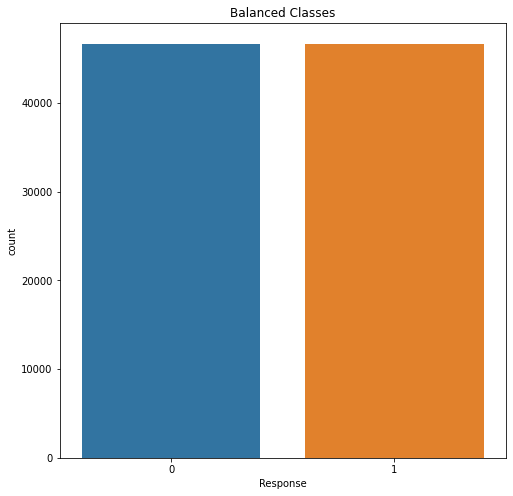

In [17]:
shuffled = df.sample(frac=1, random_state=5)
yes_response = shuffled.loc[shuffled['Response'] == 1]
no_response = shuffled.loc[shuffled['Response'] == 0].sample(n=df.loc[df['Response'] == 1]['Response'].value_counts()[1], random_state=42)

df_balanced = pd.concat([yes_response, no_response])

plt.figure(figsize=(8, 8))
sns.countplot(x='Response', data=df_balanced)
plt.title('Balanced Classes')
plt.show()

### Oversamplng
Membuat data sintesis dari kelas yang minoritas jumlahnya, pada kasus ini kelas yang minoritas adalah kelas Response 1. Menggunakan SMOTE

In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=7)

os_trainX, os_trainY = sm.fit_resample(df.drop('Response', axis=1), df['Response'])
df_balanced = pd.concat([pd.DataFrame(os_trainY), pd.DataFrame(os_trainX)], axis=1)
df_balanced.columns = df.columns

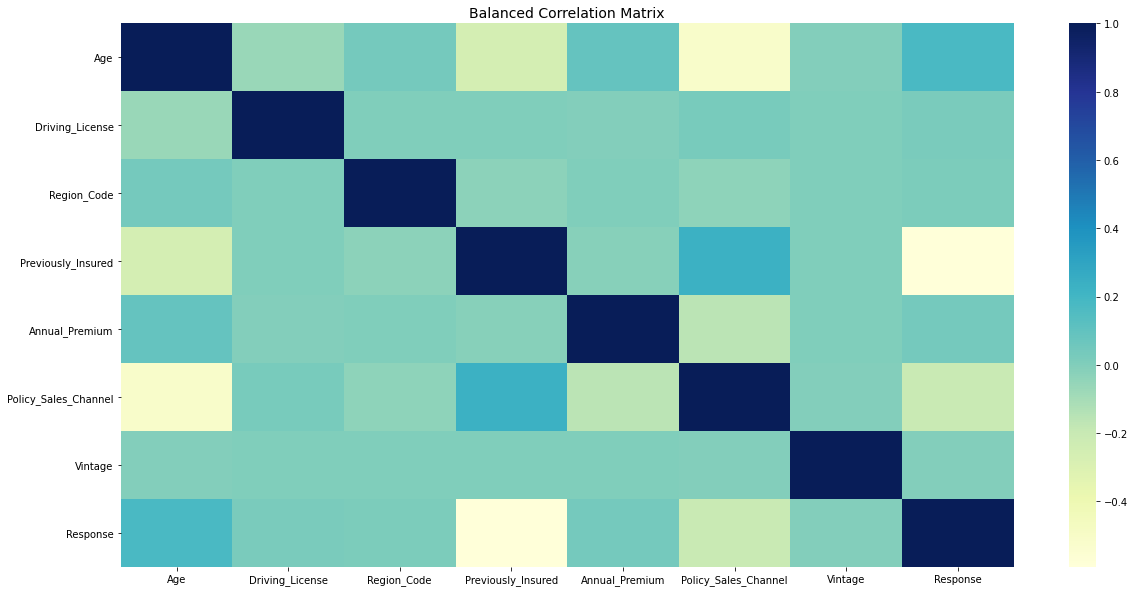

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
corr = df_balanced.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Balanced Correlation Matrix", fontsize=14)
plt.show()

### Preprocessing Train Data and Test Data

In [19]:
df_balanced['Gender'] = df_balanced['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

In [20]:
df_balanced = pd.get_dummies(df_balanced,drop_first=True)

df_balanced = df_balanced.rename(columns = {"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
df_balanced['Vehicle_Age_lt_1_Year'] = df_balanced['Vehicle_Age_lt_1_Year'].astype('int')
df_balanced['Vehicle_Age_gt_2_Years']= df_balanced['Vehicle_Age_gt_2_Years'].astype('int')

df_balanced['Vehicle_Damage_Yes'] = df_balanced['Vehicle_Damage_Yes'].astype('int')

In [21]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df_balanced[numerical] = ss.fit_transform(df_balanced[numerical])

In [22]:
categorical = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age_lt_1_Year','Vehicle_Age_gt_2_Years','Vehicle_Damage_Yes','Region_Code']

for column in categorical:
    df_balanced[column] = df_balanced[column].astype('str')

In [23]:
test = pd.read_csv('./test.csv')

test['Gender'] = test['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

test = pd.get_dummies(test,drop_first=True)

test = test.rename(columns = {"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
test['Vehicle_Age_lt_1_Year'] = test['Vehicle_Age_lt_1_Year'].astype('int')
test['Vehicle_Age_gt_2_Years']= test['Vehicle_Age_gt_2_Years'].astype('int')

test['Vehicle_Damage_Yes'] = test['Vehicle_Damage_Yes'].astype('int')

test[numerical] = ss.fit_transform(test[numerical])

categorical = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age_lt_1_Year','Vehicle_Age_gt_2_Years','Vehicle_Damage_Yes','Region_Code']

for column in categorical:
    test[column] = test[column].astype('str')
    
test=test.drop('id',axis=1)

In [24]:
train_target = df_balanced['Response']
df_balanced = df_balanced.drop(['Response'], axis = 1)
x_train,x_test,y_train,y_test = train_test_split(df_balanced,train_target, random_state = 0)

In [25]:
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2,3,4,5,6,7,10],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [300]}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 10, 
                               cv = 4, verbose= 1, random_state= 101, n_jobs = -1)
model.fit(x_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 10],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [5, 7, 10],
                                        'n_estimators': [300]},
                   random_state=101, verbose=1)

In [ ]:
y_pred=model.predict(x_test)

print(classification_report(y_test, y_pred))

In [ ]:
random_search = {'n_neighbors': [5,8,10,12],
               'weights': ['uniform', 'distance'],
               'algorithm': ['auto','ball_tree','kd_tree','brute']}

knn = KNeighborsClassifier()
model = RandomizedSearchCV(estimator = knn, param_distributions = random_search, n_iter = 10, 
                               cv = 4, verbose= 1, random_state= 101, n_jobs = -1)
model.fit(x_train, y_train)

In [ ]:
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))